# Puts ALL WISE Astrometry reference catalogues into GAIA reference frame

<img src=https://avatars1.githubusercontent.com/u/7880370?s=200&v=4>

The WISE catalogues were produced by ../dmu16_allwise/make_wise_samples_for_stacking.csh

In the catalogue, we keep:

- The position;
- The chi^2

This astrometric correction is adapted from master list code  (dmu1_ml_XMM-LSS/1.8_SERVS.ipynb) written by Yannick Rohlly and Raphael Shirley


In [1]:
field="ECDFS-FIDEL"

In [2]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
017bb1e (Mon Jun 18 14:58:59 2018 +0100) [with local modifications]


In [3]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, flux_to_mag

/home/mc741/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/home/mc741/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/mc741/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/home/mc741/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/mc741/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The 

In [4]:
OUT_DIR =  os.environ.get('TMP_DIR', "../dmu16_allwise/data/")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "servs_ra"
DEC_COL = "servs_dec"

In [5]:
## I - Reading in WISE astrometric catalogue

In [6]:
wise = Table.read(f"../dmu16_allwise/data/Allwise_PSF_stack_{field}.fits")
wise_coords=SkyCoord(wise['ra']*u.deg, wise['dec']*u.deg)

epoch = 2009

wise[:10].show_in_notebook()

idx,designation,ra,dec,sigra,sigdec,sigradec,w1mpro,w1sigmpro,w1snr,w1rchi2,w2mpro,w2sigmpro,w2snr,w2rchi2,w3mpro,w3sigmpro,w3snr,w3rchi2,w4mpro,w4sigmpro,w4snr,w4rchi2,nb,na,w1sat,w2sat,w3sat,w4sat,pmra,sigpmra,pmdec,sigpmdec,cc_flags,ext_flg,var_flg,ph_qual,moon_lev,w1nm,w1m,w2nm,w2m,w3nm,w3m,w4nm,w4m,dist,angle
0,J033229.55-274812.6,53.1231411,-27.8035084,0.5559,0.5888,-0.1836,18.054,0.187,5.8,0.9381,17.078,null,1.7,1.122,13.03,null,0.6,1.009,9.536,null,0.1,1.016,1,0,0.001,0.0,0.0,0.0,-568,1920,-2416,2029,0000,0,nnnn,BUUU,11,3,60,3,59,1,41,0,41,9.465136,321.288726
1,J033229.95-274839.3,53.1247944,-27.8109301,0.4262,0.4411,-0.1334,17.73,0.139,7.8,1.033,17.126,null,1.7,0.9547,13.142,null,-0.4,0.9158,9.658,null,-0.7,1.089,1,0,0.0,0.0,0.0,0.0,-1923,1344,-169,1411,0000,0,nnnn,BUUU,11,7,59,0,58,1,40,2,40,19.343442,181.939507
2,J033228.56-274828.2,53.1190325,-27.807859,0.34,0.3585,-0.1007,17.539,0.120,9.0,0.9868,16.917,0.268,4.0,0.9034,13.14,0.500,2.2,0.9468,9.34,null,0.5,0.9674,1,0,0.001,0.0,0.0,0.0,1062,1020,-2151,1080,0000,0,nnnn,BBCU,11,7,59,1,58,1,39,0,39,20.726443,246.463183
3,J033229.91-274756.6,53.1246496,-27.7990655,0.3479,0.365,-0.1007,17.488,0.117,9.3,0.8857,17.605,0.469,2.3,1.097,13.052,null,0.1,0.9937,9.617,null,-1.3,1.144,1,0,0.0,0.0,0.0,0.0,558,1068,611,1108,0000,0,nnnn,BCUU,11,4,59,2,59,0,41,1,41,23.406811,357.267545
4,J033228.33-274807.6,53.1180519,-27.8021137,0.1139,0.1173,-0.031,16.019,0.043,25.3,0.8748,15.973,0.114,9.6,0.8645,13.282,null,-0.3,0.9418,9.122,null,1.1,1.086,1,0,0.0,0.0,0.0,0.0,-149,254,-72,263,0000,0,0nnn,ABUU,11,54,60,3,58,0,40,0,40,25.366481,299.279654
5,J033228.80-274756.3,53.1200043,-27.798984,0.4258,0.4478,-0.1346,17.747,0.145,7.5,0.9421,17.483,0.439,2.5,0.9223,13.238,null,-0.6,0.9894,8.839,null,1.9,1.131,1,0,0.0,0.0,0.0,0.0,714,1361,-361,1423,0000,0,nnnn,BCUU,11,4,60,0,61,1,41,1,41,28.522229,326.098114
6,J033227.38-274824.4,53.1141141,-27.8067853,0.5565,0.5832,-0.1725,18.033,0.188,5.8,0.9792,17.79,null,0.0,0.8701,12.631,null,1.6,1.051,9.361,0.426,2.6,1.01,1,0,0.001,0.0,0.0,0.001,215,2011,2555,2136,0000,0,nnnn,BUUC,11,3,60,0,59,1,40,2,40,34.943619,262.745426
7,J033232.19-274845.7,53.1341621,-27.812704,0.3359,0.3548,-0.0991,17.548,0.118,9.2,0.9621,16.963,0.253,4.3,1.116,12.922,null,0.6,1.029,9.441,null,0.5,1.106,1,0,0.0,0.0,0.0,0.0,-344,1126,431,1199,0000,0,nnnn,BBUU,11,9,61,3,59,1,42,0,42,38.891757,131.399819
8,J033231.72-274852.7,53.1321696,-27.8146489,0.5997,0.6275,-0.1703,18.16,0.205,5.3,0.9661,17.592,0.438,2.5,1.027,13.003,null,0.3,1.023,9.32,null,0.7,1.021,1,0,0.0,0.0,0.0,0.0,-2096,2182,688,2308,0000,0,nnnn,BCUU,11,1,59,1,58,0,40,0,40,39.897153,145.097443
9,J033226.65-274759.3,53.11108,-27.7998192,0.5152,0.5429,-0.159,17.972,0.171,6.4,1.013,17.15,null,1.5,0.8225,13.298,null,-0.3,1.018,9.115,null,1.2,1.069,1,0,0.0,0.0,0.0,0.0,1379,1807,392,1890,0000,0,nnnn,BUUU,11,5,57,0,57,0,38,1,39,48.908129,294.993408


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [7]:
#gaia = Table.read("./dmu17_XMM-LSS/data/GAIA_XMM-LSS.fits")
print(f"../../dmu0/dmu0_GAIA/data/GAIA_{field}.fits")
gaia = Table.read(f"../../dmu0/dmu0_GAIA/data/GAIA_{field}.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

../../dmu0/dmu0_GAIA/data/GAIA_ECDFS-FIDEL.fits


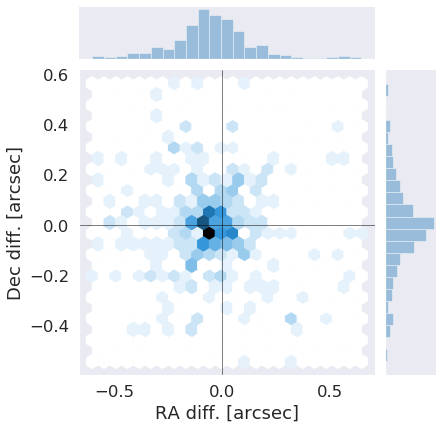

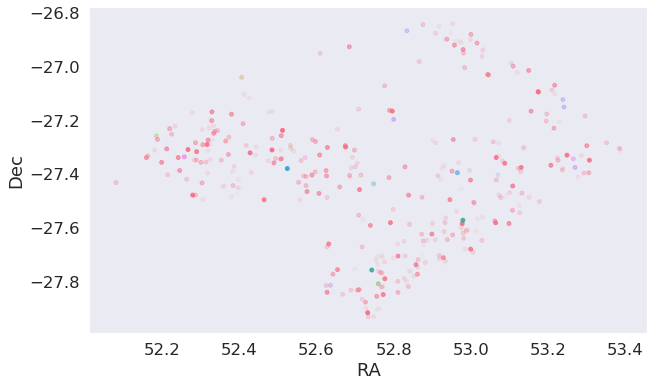

In [8]:
nb_astcor_diag_plot(wise_coords.ra, wise_coords.dec, 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

In [9]:
delta_ra, delta_dec =  astrometric_correction(
    wise_coords,
    gaia_coords, near_ra0=True
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.056881035868627805 arcsec
Dec correction: 0.0090262250473927 arcsec


In [10]:
print( wise["ra"])
print(delta_ra.to(u.deg))

    ra    
----------
53.1231411
53.1247944
53.1190325
53.1246496
53.1180519
53.1200043
53.1141141
53.1341621
53.1321696
  53.11108
       ...
52.5657278
52.9880417
52.8815414
52.2758665
52.7357694
53.4098222
53.0168636
52.6236533
52.0119432
53.7535748
53.2484441
Length = 54453 rows
1.58002877412855e-05 deg


In [12]:
#wise["ra"] +=  delta_ra.to(u.deg)
wise["ra"] = wise["ra"]*u.deg+ delta_ra.to(u.deg)
wise["dec"] = wise["dec"]*u.deg+ delta_dec.to(u.deg)

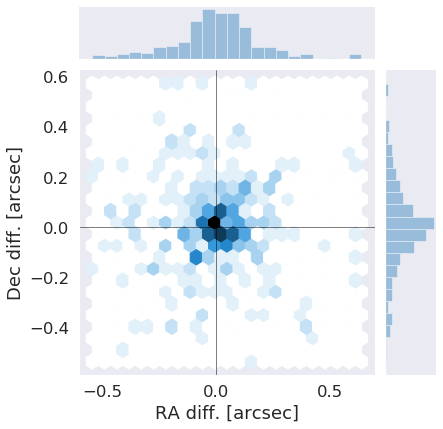

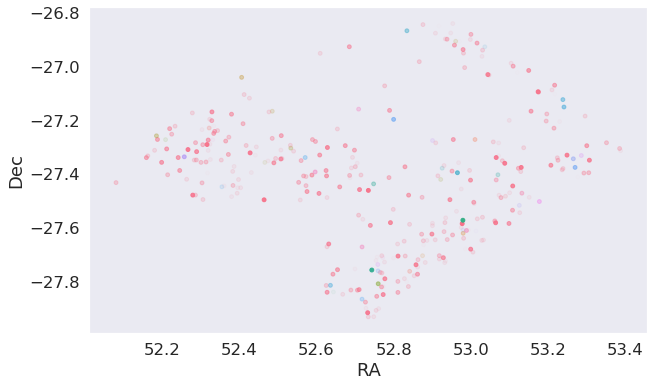

In [13]:
nb_astcor_diag_plot(wise["ra"], wise["dec"], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

## V - Saving to disk

In [14]:
wise.write(f"../dmu16_allwise/data/Allwise_PSF_stack_GAIA_{field}.fits", overwrite=True)